In [1]:
import torch
torch.manual_seed(7)
import torch.nn as nn

import numpy as np
np.random.seed(6)
# from tqdm import tqdm
# from torchvision.utils import save_image, make_grid
from torch.utils.data import TensorDataset
from torch.autograd.variable import Variable
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import sys

import random
random.seed(6)
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
# kwargs = {'num_workers': 1, 'pin_memory': True} 
num_workers = 0


In [2]:
myfile = open('wfr_out100_1.txt', 'w')
myfile.write('output printing')
  # print('output printing', file =f)

15

In [3]:
# VAE Model Hyperparameters
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #torch.device("cuda" if cuda else "cpu")
print(DEVICE)
num_classes = 10

batch_size = 50

x_dim  = 2704
hidden_dim1 = 1400
hidden_dim2 = 700
hidden_dim3 = 350
latent_dim = 32  #32

lr = 1e-4

epochs = 500

train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

cuda
True


#### Create imbalanced dataset

In [4]:
Trn_imb_set = (900, 800, 700, 600, 500, 400, 300, 200, 100, 50)
imb_index = np.insert(np.cumsum(Trn_imb_set), 0, 0)
Train_file = "Wafer_trainData.csv"
Test_file = "Wafer_testData100.csv"

In [5]:
data = np.loadtxt(Train_file, delimiter=',')
ximb_samples = torch.tensor(data[:, :-1])
yimb_samples = torch.tensor(data[:, -1])

In [6]:
ximb_samples = ximb_samples.to(torch.float32)
yimb_samples = yimb_samples.to(torch.uint8)
train_data = TensorDataset(ximb_samples,yimb_samples)

In [7]:
# train, valid = random_split(train_data,[7200,1800]) 
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=True, **kwargs)

#### Test imbalanced dataset 

In [8]:
data = np.loadtxt(Test_file, delimiter=',')
xtest_samples = torch.tensor(data[:, :-1])
ytest_samples = torch.tensor(data[:, -1])

In [9]:
xtest_samples = xtest_samples.to(torch.float32)
ytest_samples = ytest_samples.to(torch.uint8)
test_data = TensorDataset(xtest_samples,ytest_samples)

In [10]:
test_loader = DataLoader(dataset=test_data, batch_size=1000, shuffle=True, num_workers=num_workers)

#### Variational Autoencoder - VAE

In [11]:
# Encoder

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2,hidden_dim3, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim1)
        self.FC_input2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.FC_input3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_mean  = nn.Linear(hidden_dim3, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim3, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        h_       = self.LeakyReLU(self.FC_input3(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                    
                                                
        
        return mean, log_var

In [12]:
# Decoder

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1,hidden_dim2, hidden_dim3, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim3)
        self.FC_hidden2 = nn.Linear(hidden_dim3, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim1)
        self.FC_output = nn.Linear(hidden_dim1, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        h     = self.LeakyReLU(self.FC_hidden3(h))

        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [13]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)               
        z = mean + var*epsilon                          
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [14]:
encoder = Encoder(input_dim=x_dim, hidden_dim1=hidden_dim1,hidden_dim2=hidden_dim2,hidden_dim3=hidden_dim3, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim1 = hidden_dim1,hidden_dim2=hidden_dim2,hidden_dim3=hidden_dim3, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [15]:
from torch.optim import Adam
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')# nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    w_loss = x.mean() -x_hat.mean() #mean(x,x_hat) # K.mean(y_true * y_pred)

    return reproduction_loss + KLD + w_loss


optimizer_VAE = Adam(model.parameters(), lr=lr)

#### Generative Adversarial Nets - GAN

In [16]:
batch_size_GAN = 50

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128+10
        self.n_out = latent_dim #64
        self.label_embedding = nn.Embedding(10, 10)
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_features, 256),
                    nn.LeakyReLU(0.2)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(256, 512),
                    nn.LeakyReLU(0.2)
                    )
        
        self.fc3 = nn.Sequential(
                    nn.Linear(512, self.n_out),
                    nn.LeakyReLU(0.2)
                    #nn.Tanh()
                    )
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        # print(x.shape,c.shape)
        x = torch.cat([x,c], 1)
        x = self.fc0(x)
        x = self.fc1(x)
        #x = self.fc2(x)
        x = self.fc3(x)
        return x

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = latent_dim + 10 #64 + 10
        self.n_out = 1
        self.label_embedding = nn.Embedding(10, 10)

        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc2 = nn.Sequential(
                    nn.Linear(256, 128),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3)
                    )
        self.fc3 = nn.Sequential(
                    nn.Linear(128, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        #x = x.view(-1, 784)
        x = self.fc0(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [19]:
generator = Generator()
discriminator = Discriminator()

generator.to(DEVICE)
discriminator.to(DEVICE)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (fc0): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [20]:
g_optim = Adam(generator.parameters(), lr=2e-4)
d_optim = Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []

criterion = nn.MSELoss() 

In [21]:
reg_loss = nn.MSELoss()

In [22]:
def noise(n, n_features=128):
    return Variable(torch.randn(n, n_features)).to(DEVICE)

def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(DEVICE)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(DEVICE)

In [23]:
def train_discriminator(optimizer, real_data, fake_data,labels):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data,labels)
    error_real = criterion(prediction_real, make_ones(n))
    
    
    prediction_fake = discriminator(fake_data,labels)
    error_fake = criterion(prediction_fake, make_zeros(n))
    (error_real.detach()+error_fake).backward()
    optimizer.step()
    
    return error_real + error_fake

In [24]:
def structure_data(real_data,mn_vec):

  P_cov = torch.cov(real_data, correction=0)
  D, V = torch.linalg.eigh(P_cov)
  idx = torch.argsort(D, dim=0,descending = True)
  d = D[idx]
  V = V[:,idx]
  std_vec = torch.randn(batch_size_GAN, latent_dim).to(DEVICE)
  a_vec = torch.mul(std_vec.T,d)
  a_vec = torch.matmul(V.T,a_vec.T)+mn_vec

  return a_vec

In [25]:
def train_generator(optimizer, fake_data, labels,s_vec):
    n = fake_data.size(0)
    lambda1 = 0.5
    optimizer.zero_grad()
    reg1 = (reg_loss(fake_data, s_vec.detach()))
    
    reg1 *= lambda1
    
    prediction = discriminator(fake_data,labels)
    error0 = criterion(prediction, make_ones(n)) 
    
    error0 += reg1
    error0.backward()
    optimizer.step()
    
    return error0

In [26]:
def train4classes10(generator1,discriminator1,train_loader_GAN1,zxmean1):
   
  k = 1
  generator1.train()
  discriminator1.train()
  
  for epoch in range(1):
      # print(epoch)
      g_error = 0.0
      d_error = 0.0
      for i, data in enumerate(train_loader_GAN1):
          xin, yin = data
          yin = yin.type(torch.IntTensor)
          yin = torch.squeeze(yin)
          yin = yin.to(DEVICE)
          n = len(xin)
          for j in range(k):
              fake_data = generator1(noise(n),yin)#.detach()
              real_data = xin.to(DEVICE)
              d_error += train_discriminator(d_optim, real_data, fake_data,yin)

          struc_vec = structure_data(real_data,zxmean1)    
          fake_data = generator1(noise(n),yin)
          g_error += train_generator(g_optim, fake_data,yin,struc_vec)
                
  return generator1,discriminator1


#### Classifier

In [27]:
from time import time

In [28]:
class Classifier_latent(nn.Module):
    def __init__(self):
        super(Classifier_latent, self).__init__()
        self.n_in = latent_dim
        self.n_out = 10
        self.fc0 = nn.Sequential(
                    nn.Linear(self.n_in, 512),
                    nn.ReLU(),
#                     nn.Dropout(0.3)
                    )
        self.fc1 = nn.Sequential(
                    nn.Linear(512, 128),
                    nn.ReLU(),
#                     nn.Dropout(0.3)
                    )
        '''
        self.fc2 = nn.Sequential(
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    #nn.Dropout(0.3)
                    )
        '''
        
        self.fc3 = nn.Sequential(
                    nn.Linear(128, self.n_out),
                    nn.LogSoftmax(dim=1)
                    )
    def forward(self, x):
        x = self.fc0(x)
        x = self.fc1(x)
        #x = self.fc2(x)
        x = self.fc3(x)
        return x

In [29]:
clf_lat = Classifier_latent()

clf_lat.to(DEVICE)

Classifier_latent(
  (fc0): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [30]:
clf_optim =  Adam(clf_lat.parameters(), lr= 15e-4)
clf_losses = []
valid_loss = []

In [31]:
criterion_clf = nn.NLLLoss().to(DEVICE)#nn.CrossEntropyLoss() 

In [32]:
def train_classifier(optimizer, real_classes, z):
    optimizer.zero_grad()
    
    pred_classes = clf_lat(z)
    error_clf = criterion_clf(pred_classes, real_classes)
    error_clf.backward(retain_graph=True)

    optimizer.step()
    
    return 

In [33]:
# GAN setup
saved_generator = []
#saved_discriminator = []
saved_g_optim = []
#saved_d_optim = []
discriminator = Discriminator()
discriminator.to(DEVICE)
d_optim = Adam(discriminator.parameters(), lr=2e-4)

for i in range(0,9):
  generator = Generator()
  generator.to(DEVICE)
  saved_generator.append(generator)
  #saved_discriminator.append(discriminator)
  
  g_optim = Adam(generator.parameters(), lr=2e-4)
  #d_optim = Adam(discriminator.parameters(), lr=2e-4)
  saved_g_optim.append(g_optim)
  

In [34]:
max_ind = np.argmax(Trn_imb_set,)

maj_class = Trn_imb_set[max_ind]

batch_size_CLF = 100

In [35]:
maj_class

900

In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [37]:
# from torchmetrics import ConfusionMatrix

In [38]:
def metrics_aa_gm(ypred, ytrue):
    cm = confusion_matrix(ytrue, ypred)
    # print(confusion_matrix(ytrue, ypred))
    sum_classes = np.sum(cm, axis=1)
    true_pred = np.diagonal(cm)
    tp_rate = true_pred/sum_classes
    ACSA = np.mean(tp_rate)
    GM = np.prod(tp_rate)**(1/cm.shape[0])
    return ACSA, GM

In [39]:
test_loader = DataLoader(dataset=test_data, batch_size=1000, shuffle=True, num_workers=num_workers)
for batch_idx, (xtest, ytest) in enumerate(test_loader):
        xtest = xtest.view(1000, x_dim)
        xtest = xtest.to(DEVICE)
        ytest = ytest.to(DEVICE)

##### VAE training

In [40]:
# Training

model.train()
for epoch in range(epochs):
    zxmean = torch.zeros(latent_dim,9)
    train_loss = 0
    
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        # x = x.view(batch_size, 1,52,52)
        x = x.to(DEVICE)
        
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        train_loss += loss.item()
        loss.backward()
        optimizer_VAE.step()
        optimizer_VAE.zero_grad()
 
    print("\tEpoch", epoch + 1, "complete!", "\tTraining Loss: ", train_loss / (batch_idx*batch_size),)

	Epoch 1 complete! 	Training Loss:  1549.9795364583333
	Epoch 2 complete! 	Training Loss:  1435.9126545138888
	Epoch 3 complete! 	Training Loss:  1433.4434097222222
	Epoch 4 complete! 	Training Loss:  1430.8241753472223
	Epoch 5 complete! 	Training Loss:  1429.2683715277778
	Epoch 6 complete! 	Training Loss:  1428.31965625
	Epoch 7 complete! 	Training Loss:  1427.3388645833334
	Epoch 8 complete! 	Training Loss:  1425.2312083333334
	Epoch 9 complete! 	Training Loss:  1424.0752083333334
	Epoch 10 complete! 	Training Loss:  1423.0026319444444
	Epoch 11 complete! 	Training Loss:  1422.3930399305555
	Epoch 12 complete! 	Training Loss:  1421.3375711805556
	Epoch 13 complete! 	Training Loss:  1420.347217013889
	Epoch 14 complete! 	Training Loss:  1420.2105920138888
	Epoch 15 complete! 	Training Loss:  1419.7306440972222
	Epoch 16 complete! 	Training Loss:  1419.181657986111
	Epoch 17 complete! 	Training Loss:  1418.8169270833334
	Epoch 18 complete! 	Training Loss:  1418.655673611111
	Epoch 19

##### Latent samples and repeating

In [41]:
train_loader1 = DataLoader(dataset=train_data, batch_size=ximb_samples.shape[0], shuffle=False, num_workers=num_workers)
#for batch_idx, (x,_, _) in enumerate(train_loader1):
for batch_idx, (x, y) in enumerate(train_loader1):
  x = x.view(ximb_samples.shape[0], x_dim)
  # x = x.view(ximb_samples.shape[0], 1,52,52)
  x = x.to(DEVICE)
  y = y.view(ximb_samples.shape[0], 1)
  y = y.to(DEVICE)
  
_, z_mean_vae, _ = model(x) 
yimb_samples_vae =  y

for imbclass in range(1,10):
  zxmean[:,imbclass-1] =  torch.mean(z_mean_vae[(yimb_samples_vae==imbclass).reshape(ximb_samples.shape[0])],axis =0) 
  zxmean = zxmean.to(DEVICE)
  cls_sel =(y==0).reshape(ximb_samples.shape[0])
  z_mean_repeat = z_mean_vae[cls_sel,:]
  y_repeat = y[cls_sel]
  for i in range(1,10):
    cls_sel =(y==i).reshape(ximb_samples.shape[0])
    rpt_index = maj_class//y[y==i].shape[0]
    if (maj_class%(y[y==i].shape[0]) != 0):
      rpt_index += 1
      repeat_zmean = (z_mean_vae[cls_sel,:].repeat(rpt_index,1))[0:maj_class,:]
      repeat_y = (y[cls_sel].repeat(rpt_index,1))[0:maj_class,:]      
      z_mean_repeat = torch.cat((z_mean_repeat,repeat_zmean),0)
      y_repeat = torch.cat((y_repeat,repeat_y),0)

In [42]:
z_mean1 =  z_mean_repeat
yimb_samples =  y_repeat
train_data_LD = TensorDataset(z_mean1,yimb_samples)
train_loader_GAN = DataLoader(dataset=train_data_LD, batch_size=batch_size_GAN, shuffle=True, num_workers=num_workers)


###### GAN training

In [43]:
epochs = 120

In [44]:
for imbclass in range(1,10): 
  print(imbclass)  
  for epoch in range(epochs):
        
    d_optim.zero_grad()
    g_optim.zero_grad()   
     
    generator = saved_generator[imbclass-1]    
    g_optim = saved_g_optim[imbclass-1]
    
    generator_t,discriminator_t = train4classes10(generator,discriminator,train_loader_GAN,zxmean[:,imbclass-1])
    saved_generator.append(generator_t)
    generator = generator_t
    discriminator = discriminator_t

    d_optim.step()
    g_optim.step()
    


1
2
3
4
5
6
7
8
9


##### Synthetic sample generation

In [45]:
z_mean1 =  z_mean_vae #.detach().numpy() 

yimb_samples_duplicate = yimb_samples_vae#.copy()
for gen_ind in range(1,10):
  syn_gen = maj_class -  Trn_imb_set[gen_ind]
  gen1 = saved_generator[gen_ind-1]
  gen1.eval()
  fake1 = gen1(noise(syn_gen),(torch.ones(syn_gen)*gen_ind).type(torch.IntTensor).to(DEVICE))
  z_mean1 = torch.cat((z_mean1,fake1),axis=0)
  yimb_samples_duplicate = torch.cat((yimb_samples_duplicate.squeeze(),(torch.ones((syn_gen,))*gen_ind).to(DEVICE)))
  shuffled_indices = torch.randperm((z_mean1.shape[0])) #return a permutation of the indices
  
  z_mean1 = z_mean1[shuffled_indices].to(torch.float32)
  yimb_samples_duplicate = yimb_samples_duplicate[shuffled_indices].to(torch.uint8)

In [46]:
data_synth = TensorDataset(z_mean1,yimb_samples_duplicate)   
train_loader_CLF = DataLoader(dataset=data_synth, batch_size=batch_size_CLF, shuffle=True, num_workers=num_workers)

In [47]:
z_mean1.shape

torch.Size([9000, 32])

##### Classifier training

In [48]:
epochs = 400
for epoch in range(epochs):
        
    clf_lat.train()
    clf_error = 0.0
    clf_valid_error = 0.0
    for batch_idx, (z_in,labels) in enumerate(train_loader_CLF):
      #clf_optim.zero_grad()
      z_in = z_in.view(batch_size_CLF, latent_dim)
      z_in  = z_in.to(DEVICE)
      #labels = labels.view(batch_size_CLF, 1)
      labels  = labels.to(DEVICE)
      #clf_error += 
      train_classifier(clf_optim, labels, z_in)

    if (epoch >= 50 and epoch%5==0):
      model.eval()
      _, z_meantest, _ = model(xtest.to(torch.float32))
      clf_lat.eval()
      output = clf_lat((z_meantest))
      clf_pred = torch.argmax(output,dim=1)
      # Evaluation metrics
      acsa, gm = metrics_aa_gm(clf_pred.cpu().detach(), ytest.cpu().detach()) 
      myfile.write("\nEpoch=%s" %str(epoch))
      myfile.write("\tACSA=%s" %str(acsa))
      myfile.write("\tGM=%s" %str(gm))

    

In [49]:
myfile.close()

In [50]:
import random
import matplotlib.pyplot as plt

Genimages_wafer.png


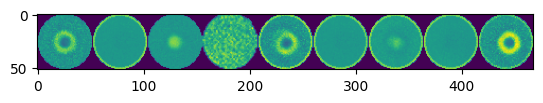

In [61]:
    sizem = 52
    tile_size = 9
    x_tile = np.zeros((sizem,sizem*(tile_size)))
    for gen_ind in range(1,10):
      gen1 = saved_generator[gen_ind-1]
      fake1 = gen1(noise(200),(torch.ones(200)*gen_ind).type(torch.IntTensor).to(DEVICE))
      # fake1 = gen1(noise(200),(torch.ones(200)*gen_ind).type(torch.IntTensor)) #gen1(noise(4000)).detach()
      n = random. randint(0,199)
      x_gen = decoder(fake1[n])
      x_gen = x_gen.reshape(sizem, sizem)
#         i_in = ind//tile_size
#         j_in = ind%tile_size
      x_tile[0:sizem,(gen_ind-1)*sizem:(gen_ind)*sizem] = x_gen.cpu().detach()
    
   
    fig = plt.figure()
    filename = "Genimages_wafer.png" 
    print(filename)
      
    plt.imshow(x_tile,)
    plt.savefig(filename)
    
    #plt.imshow(x_tile.detach().cpu().numpy())